In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from toolkit import *
import seaborn as sns
import random
import time
import warnings
warnings.filterwarnings('ignore')

def read_fasta_multilines(fasta_path, format = "fastq", num_reads=10000000):
    """
    Function to read and extract sequences from a FASTA file. It supports both plain text and gzipped files.
    Inputs:
    fasta_path: String, path to the FASTA file.
    num_records: int, maximum number of records to read.
    Returns: List of sequences.
    """
    from itertools import islice
    import gzip

    open_fn = gzip.open if fasta_path.endswith('.gz') else open
    with open_fn(fasta_path, 'rt') as file:
        records = []
        sequence = []
        record_count = 0

        for line in file:
            if line.startswith('>'):
                if sequence:
                    records.append(''.join(sequence))
                    sequence = []  # reset sequence list for the next record
                    record_count += 1
                    if record_count >= num_reads:
                        break
                # Skip processing of header line
                continue
            # Accumulate sequence lines
            sequence.append(line.strip())

        # Add the last read sequence if not already added
        if sequence and record_count < num_reads:
            records.append(''.join(sequence))

    return records


def read_fastq(fastq, format = "fastq", num_reads=10000000):
    """
    Function to read and extract sequences from a FASTQ file. It supports both plain text and gzipped files.
    Inputs:
    fastq: String, path to the FASTQ file.
    Returns: List of sequences encoded in ASCII.
    """
    open_fn = gzip.open if fastq.endswith('.gz') else open
    with open_fn(fastq, 'rt') as f:
        records = []
        line_num = 0
        while line_num<num_reads:
            header = f.readline()
            if not header: break
            seq = f.readline().strip().encode('ascii')
            if format == "fastq":
                f.readline()
                f.readline()
            records.append(seq)
            line_num+=1
    return records


def cut_sequence(sequence, length_distribution, min_len=1000, max_len=5000, p_cut=0.8, p_long=0.999):
    """
    Function to truncate sequences to a random length based on a given log-normal distribution.
    Inputs:
    sequences: List of sequences (byte strings).
    length_distribution: Tuple (shape, loc, scale) defining the parameters of the log-normal distribution.
    Returns: List of truncated sequences.
    """ 
    rndm=random.random()
    if (len(sequence)>min_len and rndm<p_cut) or (len(sequence)>max_len and rndm<p_long):
        shape, loc, scale = length_distribution
        cut_length = int(stats.lognorm.rvs(shape, loc, scale))
        cut_length = min(cut_length, len(sequence))
        return sequence[:cut_length]
    else:
        return sequence


def plot_dist(lengths_real, dist):
    """
    Compares real read length dist to lognorm
    """
    shape, loc, scale = dist

    bins=700
    plt.hist(lengths_real, bins=bins, alpha=0.5, color='g', density=True, label='Real Data')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, bins)
    p = stats.lognorm.pdf(x, shape, loc, scale)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: shape = %.2f, scale = %.2f" % (shape, scale)
    plt.title(title)
    plt.xlim(0,3000)
    plt.legend()
    plt.show() 


def calculate_aic(n, log_likelihood, k):
    """
    Calculate Akaike Information Criterion.
    :param n: Number of data points
    :param log_likelihood: Maximum log likelihood of the model
    :param k: Number of parameters in the model
    :return: AIC value
    """
    return 2 * k - 2 * log_likelihood


def plot_dist_and_calculate_aic(lengths_real, dist_type):
    """
    Fits a distribution, plots it, and calculates the AIC.
    """
    if dist_type == 'lognorm':
        params = stats.lognorm.fit(lengths_real, floc=0)
        dist_label = 'Log-Normal'
        pdf_func = stats.lognorm.pdf
    elif dist_type == 'gamma':
        params = stats.gamma.fit(lengths_real, floc=0)
        dist_label = 'Gamma'
        pdf_func = stats.gamma.pdf
    elif dist_type == 'weibull':
        params = stats.weibull_min.fit(lengths_real, floc=0)
        dist_label = 'Weibull'
        pdf_func = stats.weibull_min.pdf
    
    shape, loc, scale = params
    estimated_pdf = pdf_func(lengths_real, shape, loc, scale)
    log_likelihood = np.sum(np.log(estimated_pdf))

    aic = calculate_aic(len(lengths_real), log_likelihood, 3)  # 3 parameters: shape, loc, scale

    bins = 1000
    plt.hist(lengths_real, bins=bins, alpha=0.5, color='g', density=True, label='Real Data')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, bins)
    p = pdf_func(x, *params)
    plt.plot(x, p, 'k', linewidth=2, label=dist_label)
    plt.title(f"{dist_label} Fit: AIC = {aic*10e-6:.2f}")
    plt.xlim(0, 3000)
    plt.legend()
    plt.savefig(f"{dist_type}.pdf", format="pdf")
    plt.show()
    
    return dist_label, aic

In [2]:
lengths_real = lengths("../../paper/SC3pv3_GEX_Human_PBMC_ONT_1M.fastq") 
mean_length = np.mean(lengths_real)
median_length = np.median(lengths_real)
print("Mean length:", mean_length)
print("Median length:", median_length)

Processed: 1000000read [00:09, 106904.77read/s]


Mean length: 891.420029
Median length: 806.0


## Comparison between Ensembl cDNA and real reads lengths.

<Axes: ylabel='Density'>

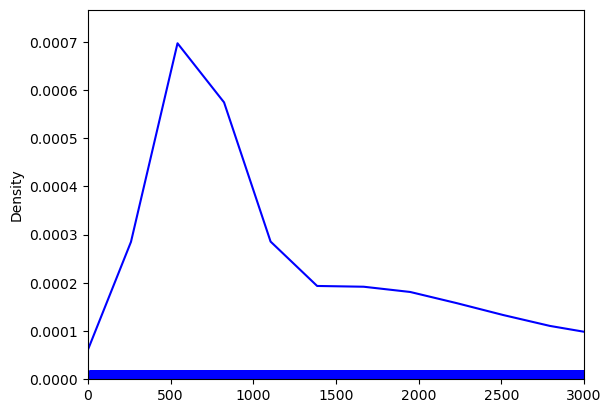

In [7]:
plt.xlim(0, 3000)
nseq=100000

cdna_sequences = read_fasta_multilines("../../../SLSim/data/cdna/Homo_sapiens.GRCh38.cdna.all.fa", "fasta")

cdna_lengths = [len(seq) for seq in cdna_sequences]
sns.distplot(cdna_lengths[:nseq], hist=False, rug=True, color="blue")

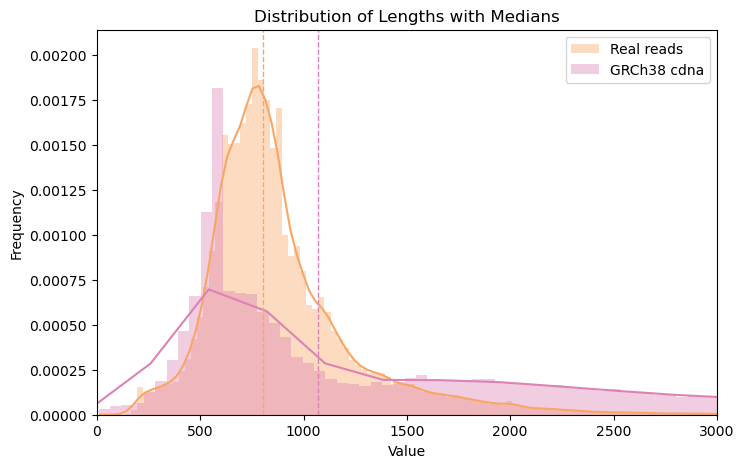

In [22]:
median_lengths_real = np.median(lengths_real[:nseq])
median_cut_lengths = np.median(cdna_lengths[:nseq])

plt.figure(figsize=(8, 5))
sns.distplot(lengths_real[:nseq], bins=200, hist=True, color='#F9A665', label='Real reads')
sns.distplot(cdna_lengths[:nseq], bins=1000, hist=True, color='#DC82B5', label='GRCh38 cdna')


plt.axvline(median_lengths_real, color='#F9A665', linestyle='dashed', linewidth=1)
plt.axvline(median_cut_lengths, color='#DC82B5', linestyle='dashed', linewidth=1)

plt.xlim(0, 3000)
plt.legend()
plt.xlabel('lengths')
plt.ylabel('Frequency')
plt.title('Distribution of Lengths with Medians')
plt.savefig('real_vs_annotation.pdf', format="pdf")

Ensembl cDNA (median 1068 pb); real reads lengths (median = 805 bp)

## Read length estimation

To approximate the observed distribution of read lengths, we first identified the statistical distribution that best describes the real dataset. 

Based on the comparison of the AIC values, we determined that the log-normal distribution best approximates the read length distribution.

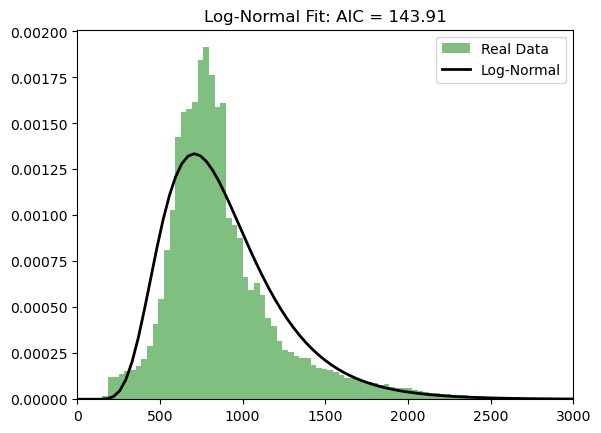

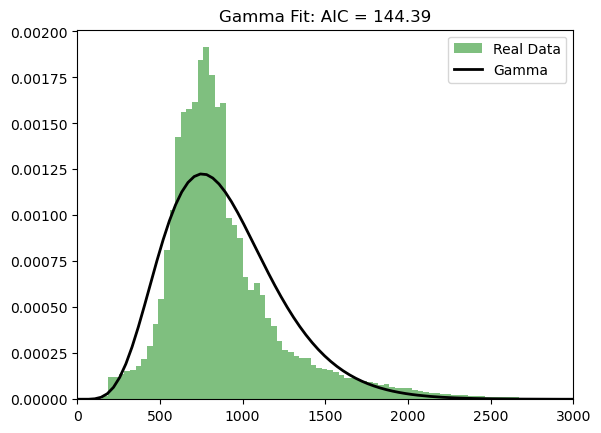

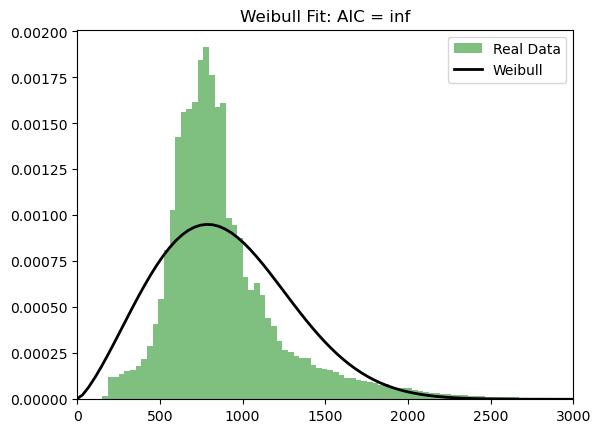

Log-Normal AIC: 143.9117808577712
Gamma AIC: 144.387800289498
Weibull AIC: inf


In [3]:
dist_types = ['lognorm', 'gamma', 'weibull']
results = []
for dist_type in dist_types:
    label, aic = plot_dist_and_calculate_aic(lengths_real, dist_type)
    results.append((label, aic))

for result in results:
    print(f"{result[0]} AIC: {result[1]*10e-6}")

Then, we fit a log-normal distribution to the real read lengths. 

In [4]:
filtered_lengths_real = [length for length in lengths_real]
shape, loc, scale = stats.lognorm.fit(lengths_real, floc=0)
print(shape, loc, scale)

0.391467629632629 0.0 824.271494768817


## Comparison between simulated reads and real reads lengths

<Axes: ylabel='Density'>

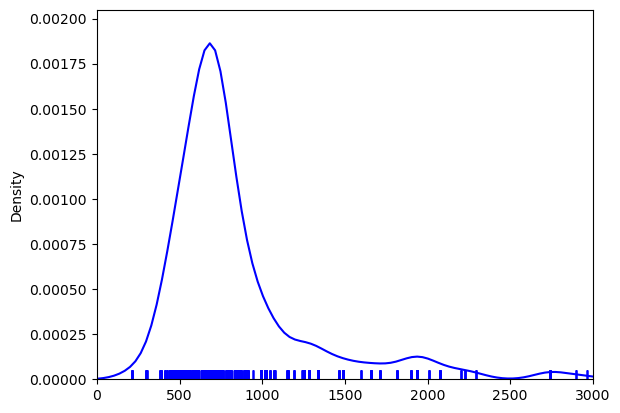

In [10]:
plt.xlim(0, 3000)
nseq=100000

sim_sequences = read_fastq("../../paper/PBMC_test_cut_small/template.fa", "fasta", num_reads=nseq)

sim_lengths = [len(seq) for seq in sim_sequences]
sns.distplot(sim_lengths[:nseq], hist=False, rug=True, color="blue")

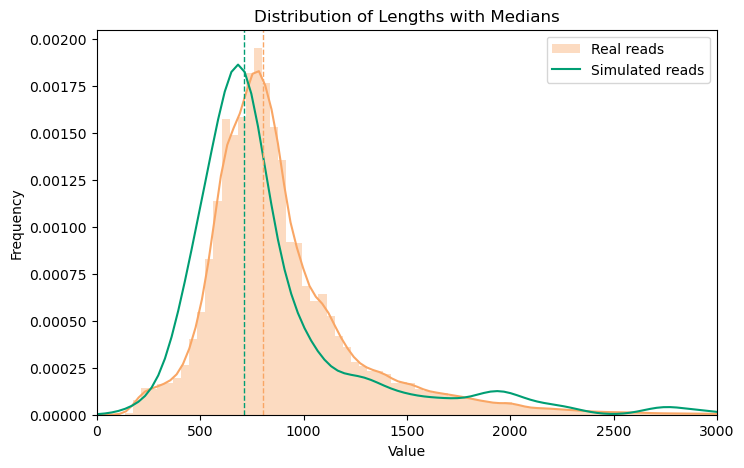

In [23]:
median_lengths_real = np.median(lengths_real[:nseq])
median_lengths_sim = np.median(sim_lengths[:nseq])

plt.figure(figsize=(8, 5))
sns.distplot(lengths_real[:nseq], hist=True, bins = 150, color='#F9A665', label='Real reads')
sns.distplot(sim_lengths[:nseq], hist=False, kde=True,  color="#009E73", label='Simulated reads')

plt.axvline(median_lengths_real, color='#F9A665', linestyle='dashed', linewidth=1)
plt.axvline(median_lengths_sim, color='#009E73', linestyle='dashed', linewidth=1)

plt.xlim(0, 3000)
plt.legend()
plt.xlabel('lengths')
plt.ylabel('Frequency')
plt.title('Distribution of Lengths with Medians')
plt.savefig('real_vs_simulation.pdf', format="pdf")

In [25]:
print(np.median(lengths_real[:nseq]))
print(np.median(sim_lengths[:nseq]))
print(np.median(cdna_lengths[:nseq]))

805.0
714.0
1068.0
